In [1]:
!which python
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/twin-polyak/experiments


In [2]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict
import pickle

import numpy as np

import matplotlib.pyplot as plt

import utils
from utils import moving_average
from solve_binary_libsvm import solve_binary_libsvm

from npkit.data import NumpyDataLoader
from npkit.loss import LogisticRegressionLoss, LegacyLogisticRegressionLoss
from npkit.optim import Adam, STP

import sklearn
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split

from tqdm import tqdm
import scipy
import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

True

In [40]:
import wandb

api = wandb.Api()
entity, project = "farshed-mbzuai", "TwinPolyak"
runs = api.runs(entity + "/" + project, )


history_list = []
for run in runs:
    if len(run.config) > 0 and run.config['dataset/name'] == 'MNIST' and run.config['config']['optimizer'] == 'Adam':
        print(run.config)
        hist = run.history()
        hist['optimizer'] = 'Adam'
        hist['seed'] = run.config['config']['seed']
        hist['label'] = f"{run.config['config']['optimizer']} lr={run.config['config']['optimizer_hparams']['lr']}"
        history_list.append(hist)


{'model': 'LeNet5', 'config': {'reg': 0, 'seed': 0, 'optimizer': 'Adam', 'batch_size': 256, 'max_epochs': 50, 'optimizer_hparams': {'lr': 0.01}}, 'dataset/name': 'MNIST'}
{'model': 'LeNet5', 'config': {'reg': 0, 'seed': 1, 'optimizer': 'Adam', 'batch_size': 256, 'max_epochs': 50, 'optimizer_hparams': {'lr': 0.01}}, 'dataset/name': 'MNIST'}
{'model': 'LeNet5', 'config': {'reg': 0, 'seed': 2, 'optimizer': 'Adam', 'batch_size': 256, 'max_epochs': 50, 'optimizer_hparams': {'lr': 0.01}}, 'dataset/name': 'MNIST'}
{'model': 'LeNet5', 'config': {'reg': 0, 'seed': 3, 'optimizer': 'Adam', 'batch_size': 256, 'max_epochs': 50, 'optimizer_hparams': {'lr': 0.01}}, 'dataset/name': 'MNIST'}
{'model': 'LeNet5', 'config': {'reg': 0, 'seed': 4, 'optimizer': 'Adam', 'batch_size': 256, 'max_epochs': 50, 'optimizer_hparams': {'lr': 0.01}}, 'dataset/name': 'MNIST'}


<Axes: xlabel='epoch', ylabel='val_acc'>

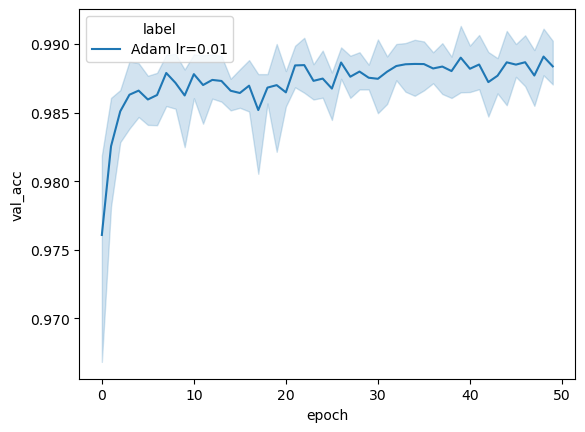

In [51]:
import seaborn as sns 
import pandas as pd


df = pd.concat(history_list, ignore_index=True)

df

sns.lineplot(
    data=df,
    x='epoch',
    y='val_acc',
    hue='label',
    estimator='mean',
    errorbar=('pi', 90),
    style='label',
)

In [214]:
from exp_a1a import A1ANumpyDataModule
from libsvm_binary_classifier import NumpyLibSVMBinaryClassifier
import npkit

import pandas as pd

histories = []
for seed in [0, ]:
    config = {
        'seed': seed,
        'batch_size': 128,
        'max_epochs': 100,
        'optimizer': 'STP',
        'optimizer_hparams': {
            'beta': 0.9,
            # 'eps': 1e-8,
            # 'lr': lr,
        }
    }

    np.random.seed(config['seed'])

    datamodule = A1ANumpyDataModule(batch_size=config['batch_size'])
    classifier = NumpyLibSVMBinaryClassifier(dataset_name=datamodule.dataset, 
                                            input_dim=datamodule.num_features,
                                            config=config, 
                                            max_epochs=config['max_epochs'])
    classifier.fit(datamodule=datamodule)

{'beta': 0.9}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 35.68it/s]


<Axes: xlabel='epoch', ylabel='lr'>

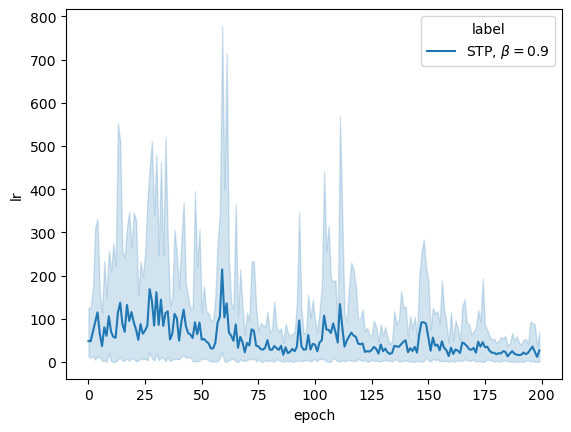

In [113]:
db = pd.read_csv('np_experiments_db.csv')
dataset_name = 'a1a'
optimizer = 'STP'
betas = [0.9, ]

df = db[(db['dataset'] == dataset_name) & (db['optimizer'] == optimizer)]
df = df[(df['batch_size'] == 128)]
df = df[(df['max_epochs'] == 200)]
lrs_mask = df['optimizer_hp_beta'].isin(betas)
df = df[lrs_mask]
df.sort_values('optimizer_hp_beta', inplace=True)

all_runs = []
for _, row in df.iterrows():
    metrics = pd.read_csv(f"{row['metrics_path']}/metrics.csv")
    metrics['optimizer'] = row['optimizer']
    metrics['seed'] = row['seed']
    metrics['optimizer_hp_beta'] = row['optimizer_hp_beta'] if 'optimizer_hp_beta' in row else np.nan
    metrics['label'] = optimizer + r", $\beta=$" + str(row['optimizer_hp_beta'])
    all_runs.append(metrics)

curves2 = pd.concat(all_runs, ignore_index=True)

import seaborn as sns

sns.lineplot(
    data=curves2,
    x='epoch',
    y='lr',
    hue='label',
    errorbar=('pi', 90),
    estimator='mean',
    style='label',
    markersize=10,
)

{'beta': 0.9}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 54.35it/s]


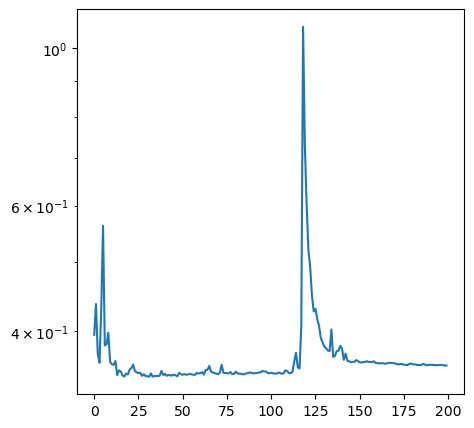

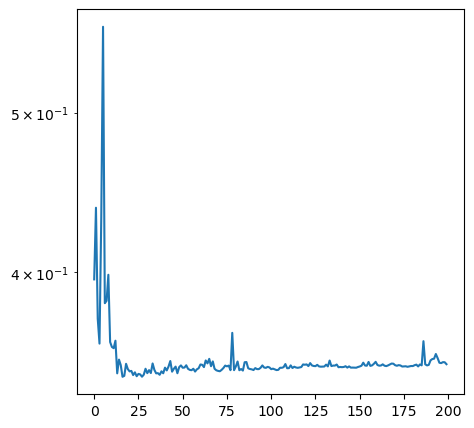

In [217]:
class A1ANumpyDataModule:
    def __init__(self, data_dir: str = os.getenv("LIBSVM_DIR"), batch_size: int = 64):
        super().__init__()

        self.dataset = 'a1a'
        self.batch_size: int = batch_size
        self.num_samples: int = 1_605
        self.num_features: int = 123
        self.num_labels: int = 2
        
        train_data, train_target = sklearn.datasets.load_svmlight_file(f'{data_dir}/{self.dataset}', n_features=self.num_features)
        train_data = sklearn.preprocessing.normalize(train_data, norm='l2', axis=1)
        train_target = utils.map_classes_to(train_target, [-1.0, 1.0])

        val_data, val_target = sklearn.datasets.load_svmlight_file(f'{data_dir}/{self.dataset}.t', n_features=self.num_features)
        val_data = sklearn.preprocessing.normalize(val_data, norm='l2', axis=1)
        val_target = utils.map_classes_to(val_target, [-1.0, 1.0])
        
        assert np.all(np.sort(np.unique(train_target)) == [-1.0, 1.0])
        assert np.all(np.sort(np.unique(val_target)) == [-1.0, 1.0])

        self.train_data, self.train_target = train_data, train_target
        self.val_data, self.val_target = val_data, val_target

        self.train_dataloader = NumpyDataLoader(train_data, train_target, batch_size=self.batch_size, shuffle=True, drop_last=False)
        self.val_dataloader = NumpyDataLoader(val_data, val_target, batch_size=self.num_samples, shuffle=False, drop_last=False) # `batch_size` == dataset size because it is a small dataset

fig = plt.figure(figsize=(5, 5))

for seed in [0, ]:

    config = {
            'seed': seed,
            'batch_size': 256,
            'max_epochs': 200,
            'optimizer': 'STP',
            'optimizer_hparams': {
                'beta': 0.9,
                # 'eps': 1e-8,
                # 'lr': lr,
            }
        }
    
    np.random.seed(config['seed'])
    datamodule = A1ANumpyDataModule(batch_size=config['batch_size'])

    classifier = NumpyLibSVMBinaryClassifier(dataset_name=datamodule.dataset, 
                                            input_dim=datamodule.num_features,
                                            config=config, 
                                            max_epochs=config['max_epochs'])
    classifier.fit(datamodule=datamodule)
    
    plt.semilogy(classifier.logger.storage['val_loss'])

fig.show()


fig = plt.figure(figsize=(5, 5))

for seed in [0, ]:

    datamodule = A1ANumpyDataModule(batch_size=256)

    history = stp(datamodule, 200, 0.9, seed)
    
    plt.semilogy(history['test/loss'])

fig.show()

In [212]:
def stp(datamodule, n_epochs, beta, seed=0):
    np.random.seed(seed)

    # parameters
    params_x = np.random.randn(datamodule.num_features)
    params_y = np.random.randn(datamodule.num_features)

    # oracle 
    loss_function = LegacyLogisticRegressionLoss(lmd=0.0)

    # logging 
    history = defaultdict(list)

    fm_x = 0.0
    gm_x = np.zeros_like(params_x)
    gamma_x = 0.0

    fm_y = 0.0
    gm_y = np.zeros_like(params_y)
    gamma_y = 0.0

    eps = 1e-8

    for epoch in range(n_epochs):
        
        for X, y in datamodule.train_dataloader:
                        
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, X, y)
            loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, X, y)

            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, params_x)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + (np.dot(gm_x, params_x) - gamma_x)
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, params_y)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, params_y) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                params_x -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                params_y -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, datamodule.train_data, datamodule.train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, datamodule.train_data, datamodule.train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, datamodule.val_data, datamodule.val_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, datamodule.val_data, datamodule.val_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

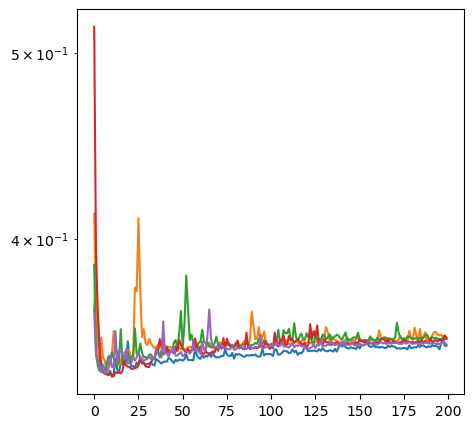

In [163]:
fig = plt.figure(figsize=(5, 5))

for seed in [0, 1, 2, 3, 4]:

    datamodule = A1ANumpyDataModule(batch_size=128)

    history = stp(datamodule, 200, 0.9, seed)
    
    plt.semilogy(history['test/loss'])

fig.show()

0       129.209133
1        43.033660
2        69.404378
3        24.501751
4        53.831850
           ...    
9595     13.068572
9596     21.462930
9597           NaN
9598           NaN
9599           NaN
Name: lr, Length: 9600, dtype: float64

In [ ]:
def mean_max_min(l):
    max_length = max(len(sublist) for sublist in l)
    
    mean_line = []
    max_line = []
    min_line = []
    for i in range(max_length):
        values_at_position = [sublist[i] for sublist in l if i < len(sublist)]
        mean_line.append(np.mean(values_at_position))
        max_line.append(np.max(values_at_position))
        min_line.append(np.min(values_at_position))

    return mean_line, max_line, min_line


mean_line, max_line, min_line = mean_max_min(res)
ax[ax_idx].fill_between(x, max_line, min_line, color=c, alpha=0.2)
ax[ax_idx].plot(x, mean_line, label=lbl, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)   
ax[ax_idx].set_yscale(y_scales[ax_idx])

In [10]:
import sklearn.model_selection


np.random.seed(0)
n = 5_000
d = 100
dataset_name = "synthetic-interpolation"

data, target = sklearn.datasets.make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=1, class_sep=3.0, random_state=0)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])

L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T @ train_data, ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

oracle = LogisticRegressionLoss()
w = np.random.randn(train_data.shape[1])
train_result = scipy.optimize.minimize(
        fun=oracle.func,
        jac=oracle.grad,
        x0=w,
        args=(train_data, train_target),
        method="L-BFGS-B"
    )

test_result = scipy.optimize.minimize(
    fun=oracle.func,
    jac=oracle.grad,
    x0=w,
    args=(test_data, test_target),
    method="L-BFGS-B"
)
    
b = {
    "dataset_name": dataset_name,
    "train/f_star": oracle.func(train_result.x, train_data, train_target),
    "test/f_star": oracle.func(test_result.x, test_data, test_target),
    "train/x_star": train_result.x,
    "test/x_star": test_result.x
}

    
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]
print(f"{train_f_star=}")
print(f"{test_f_star=}")

dataset = train_data, train_target, test_data, test_target

L=2.4476005045688796
1/L=0.40856340654176326
np.unique(train_target)=array([-1.,  1.])


NotImplementedError: 

In [ ]:
np.random.seed(0)
n = 2000
d = 100
dataset_name = "synthetic-no-interpolation"

data, target = sklearn.datasets.make_classification(n_samples=n, n_features=d, n_redundant=0, n_clusters_per_class=2, class_sep=0.1, random_state=0)
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.2, random_state=0)

train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
test_target = utils.map_classes_to(test_target, [-1.0, 1.0])


L = (0.25 / train_data.shape[0]) * np.linalg.norm(train_data.T.dot(train_data), ord=2)

# batch_size = train_data.shape[0]
batch_size = 100

print(f"{L=}")
print(f"{1/L=}")
print(f"{np.unique(train_target)=}")

dataset = train_data, train_target, test_data, test_target

L=0.3813798712150801
1/L=2.622057626727887
np.unique(train_target)=array([-1.,  1.])


In [ ]:
dataset_name = "colon-cancer"
trainX, trainY, testX, testY = utils.get_libsvm(dataset_name, test_split=0.0)

trainY = utils.map_classes_to(trainY, [-1.0, 1.0])
testY = utils.map_classes_to(testY, [-1.0, 1.0])

train_data, train_target = sklearn.preprocessing.normalize(trainX, norm='l2', axis=1), trainY
test_data, test_target = sklearn.preprocessing.normalize(testX, norm='l2', axis=1), testY

b = solve_binary_libsvm(train_data, train_target, test_data, test_target)
train_f_star, train_x_star, test_f_star, test_x_star = b["train/f_star"], b["train/x_star"], b["test/f_star"], b["test/x_star"]

L = (0.25 / train_data.shape[0]) * scipy.sparse.linalg.norm(train_data.T @ train_data, ord=2)

dataset = train_data, train_target, test_data, test_target

# batch_size = train_data.shape[0]
batch_size = 10
setting = "Deterministic" if batch_size == train_data.shape[0] else "Stochastic"

print(f"{train_f_star=}")
print(f"{test_f_star=}")
print(f"{1/L=}")
print(f"{batch_size=}")
print(f"{train_data.shape=}, {test_data.shape=}")
print(f"{np.unique(train_target)=}, {np.unique(test_target)=}")

NotImplementedError: 

{'beta': 0.9}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.83it/s]


[69.93027459454049,
 119.0869076060476,
 57.087351963305714,
 157.7939967450293,
 115.90662627434847,
 62.24572878496715,
 63.02721495037863,
 95.55910484745583,
 37.46243720282516,
 109.89422598612487,
 35.78686672643102,
 102.03023158910233,
 37.553217019387255,
 39.789106101287395,
 47.83974230000312,
 6.084451539381784,
 22.15600038021434,
 57.6428563005386,
 21.44280714618927,
 80.73692239679647,
 18.22007297371127,
 37.76912180493653,
 24.856818875099602,
 33.827411581572825,
 72.00473007393546,
 174.4892441670213,
 121.21280204736925,
 75.58147941818191,
 23.629701636386738,
 18.575573809723384,
 32.6431051187038,
 17.13085245487695,
 48.655977182633535,
 37.94892360112616,
 23.44050116024379,
 33.669917048651996,
 37.171406978547175,
 30.946848372876005,
 23.445493065550174,
 48.79916321100427,
 10.008918202481736,
 16.614772081401725,
 19.71105958000627,
 46.38306660401182,
 32.165660983813034,
 9.536427725170052,
 30.52937310368322,
 103.6009707569345,
 85.62859140137202,
 97

In [ ]:
def plotter(histories, labels, colors=None, linestyles=None, 
            linewidths=None, markers=None, markeredgecolor=None, markersize=8,
            alphas=None, f_star=None, suptitle=None, prefix="train",
            x_labels=None, y_labels=None,
            threshold=1e-10, xlims=None, apply_ma=True,
            tight_layout=True, filename=None):
    
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)
        
    if colors is None:
        colors = list(plt.cm.colors.XKCD_COLORS.keys())
        np.random.shuffle(colors)
        colors = list(plt.cm.colors.BASE_COLORS) + colors
        
    if linestyles is None:
        linestyles = ["-" for x in histories]
    
    if linewidths is None:
        linewidths = [1.5 for x in histories]
        
    if markers is None:
        markers = [" " for x in histories]
    
    if alphas is None:
        alphas = [1.0 for x in histories]

    ma_factor = lambda x: x // 20 if apply_ma else 0
        
    for history, label, c, ls, lw, m, alpha in zip(histories, labels, colors, linestyles, linewidths, markers, alphas):
        if not f_star:
            f_suboptim = history[f"{prefix}/loss"]
        else:
            f_suboptim = history[f"{prefix}/loss"] - f_star
        
        f_suboptim = moving_average(f_suboptim, ma_factor(len(f_suboptim)))

        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history[f"{prefix}/loss"]) - 5, len(history[f"{prefix}/loss"]) // 10)]
        except:
            markevery = []
        
        ax[0].semilogy(f_suboptim, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        res = history[f"{prefix}/grad_norm_sq"]
        res = moving_average(res, ma_factor(len(res)))
        ax[1].semilogy(res, linestyle=ls, linewidth=lw, color=c, label=label, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        ax[2].plot(history[f"test/acc"], linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        
        try:
            markevery = [0, ] + [x + np.random.randint(0, 5) for x in range(0, len(history["lr"]) - 5, len(history["lr"]) // 5)]
        except:
            markevery = []
        
        res = history["lr"]
        res = moving_average(res, ma_factor(len(res)))
        if alpha != 1.0:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, alpha=alpha)
            ax[3].semilogy(moving_average(res, ma_factor(len(f_suboptim))), linestyle=ls, linewidth=lw, color=c, alpha=1.0, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)
        else:
            ax[3].semilogy(res, linestyle=ls, linewidth=lw, color=c, markevery=markevery, marker=m, markeredgecolor=markeredgecolor, markersize=markersize)

    if f_star == 0.0:
        ax[0].set_ylabel(r"$f(x_k)$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
    else:
        ax[0].set_ylabel(r"$f(x_k) - f^*$")
        ax[1].set_ylabel(r"$\| \nabla f(x_k) \|^2$")
        
    ax[2].set_ylabel("Test Accuracy")
    ax[3].set_ylabel("step-size")
    
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[2].set_xlabel("Epochs")
    ax[3].set_xlabel("Steps")
    
    # ax[3].tick_params(axis='x', rotation=45)


    if xlims is not None:
        ax[1].set_xlim(right=xlims[1])
    
    fig.legend()

    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()

    if tight_layout:
        fig.tight_layout()
        
    if filename is not None:
        directory = "plots/" + datetime.datetime.today().strftime("%d-%m-%Y")
        if not os.path.exists(directory):
            os.makedirs(directory)
        fig.savefig(directory + "/" + filename)
    else:
        fig.show()

In [ ]:
np.random.seed(seed)
datamodule2 = ColonCancerNumpyDataModule(batch_size=config['batch_size'])

hist_tp_old = twin_polyak_ma(
    datamodule=datamodule2,
    n_epochs=config['max_epochs'],
    seed=seed,
    beta=config['optimizer_hparams']['beta']
)


NEW


In [ ]:
classifier.logger['model_y'][0][:10], hist_tp_old['model_y'][0][:10]

(array([ 0.48951662,  0.23879586, -0.44811181, -0.610795  , -2.02994507,
         0.60794659, -0.35410888,  0.15258149,  0.50127485, -0.78640277]),
 array([ 0.48951662,  0.23879586, -0.44811181, -0.610795  , -2.02994507,
         0.60794659, -0.35410888,  0.15258149,  0.50127485, -0.78640277]))

In [ ]:
config = {
    'batch_size': 16,
    'max_epochs': 100,
    'optimizer': Adam,
    'optimizer_hparams': {
        'lr': 0.1,
    }
}

np.random.seed(seed)
datamodule = ColonCancerNumpyDataModule(batch_size=config['batch_size'])

classifier_adam = NumpyLibSVMBinaryClassifier(input_dim=datamodule.num_features,
                                   config=config, 
                                   max_epochs=config['max_epochs'])
classifier_adam.fit(datamodule=datamodule)

{'lr': 0.1}


In [ ]:
np.random.seed(seed)
datamodule = ColonCancerNumpyDataModule(batch_size=config['batch_size'])

hist_adam_old = train_loop(
    datamodule=datamodule,
    n_epochs=config['max_epochs'],
    optimizer=Adam,
    seed=seed,
    lr=config['optimizer_hparams']['lr'],
)

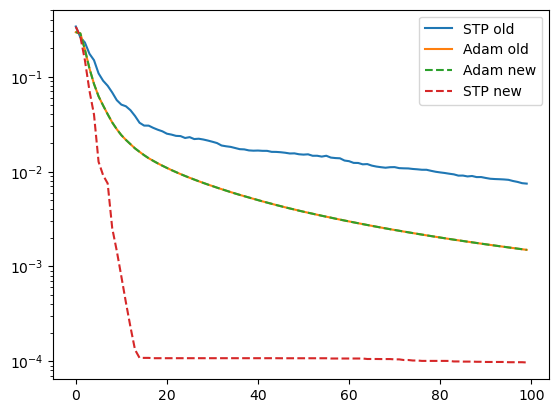

In [ ]:
hist = classifier.logger['val_loss']
hist_adam = classifier_adam.logger['val_loss']

plt.semilogy(hist_tp_old['val_loss'], label='STP old')
plt.semilogy(hist_adam_old['val_loss'], label='Adam old')
plt.semilogy(hist_adam, label='Adam new', linestyle='--')
plt.semilogy(hist, label='STP new', linestyle='--')

plt.legend()

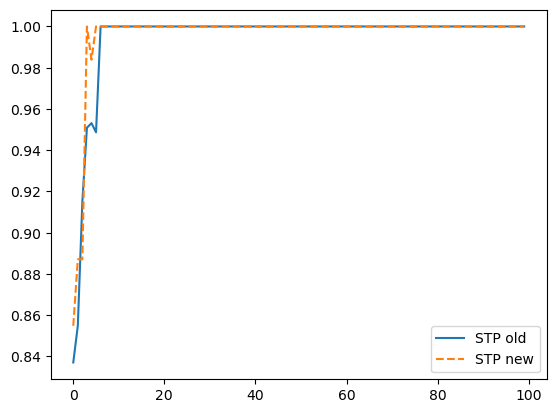

In [ ]:
hist = classifier.logger['val_acc']
hist_adam = classifier_adam.logger['val_acc']

plt.plot(hist_tp_old['val_acc'], label='STP old')
# plt.plot(hist_adam_old['val_acc'], label='Adam old')
# plt.plot(hist_adam, label='Adam new', linestyle='--')
plt.plot(hist, label='STP new', linestyle='--')

plt.legend()

In [ ]:
hist2['test/loss'][-1], hist[-1], test_f_star

(0.007463331611420094, 9.692586809945216e-05, 0.0005205630857871723)

In [ ]:
def train_loop(datamodule, 
               n_epochs: int,
               optimizer: BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)
    
    # params = np.zeros(train_data.shape[1])
    # params = np.random.randn(datamodule.num_features)
    model = NumpyLinearModel(input_dim=datamodule.num_features)
    
    optim = optimizer(model.params, **optimizer_kwargs)

    # oracle 
    loss_function = LegacyLogisticRegressionLoss(lmd=0.0)

    # logging 
    history = defaultdict(list)

    logger = NumpyLogger()
    
    for epoch in range(n_epochs):

        for batch in datamodule.train_dataloader:
            batch_data, batch_target = batch
        
            train_loss, train_grad, train_acc = loss_function.func_grad_acc(model.params, batch_data, batch_target)

            if optim.__class__.__name__ == "SLS":
                def closure(params):
                    return loss_function.func(params, batch_data, batch_target)
                optim.step(loss=train_loss, grad=train_grad, closure=closure)
            else:
                optim.step(loss=train_loss, grad=train_grad)
            
            g_norm_sq = np.linalg.norm(train_grad)**2
            history["train/batch/loss"].append(train_loss)
            history["train/batch/acc"].append(train_acc)
            history["train/batch/grad_norm_sq"].append(g_norm_sq)  

            history["lr"].append(optim.lr)

        logger.reset()
        for batch in datamodule.val_dataloader:
            batch_data, batch_target = batch
        
            # Test Evaluation 
            loss, grad, acc = loss_function.func_grad_acc(model.params, batch_data, batch_target)
            g_norm_sq = np.linalg.norm(grad)**2

            logger.log('val_loss', loss)
            logger.log('val_acc', acc)

        logger.compute_on_epoch()
        
    return logger

In [ ]:
def twin_polyak_ma_new(datamodule, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 1e-8,
               ) -> dict: 
    
    print("NEW!!")
    
    # np.random.seed(seed)

    # parameters
    model = [
        NumpyLinearModel(input_dim=datamodule.num_features),
        NumpyLinearModel(input_dim=datamodule.num_features)
    ]

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    metric_accuracy = LogisticRegressionAccuracy()
    
    # logging 
    history = defaultdict(list)
    logger = NumpyLogger()

    logger.log('model_x', model[0].params.copy(), on_epoch=False)
    logger.log('model_y', model[1].params.copy(), on_epoch=False)

        
    fm_x = 0.0
    gm_x = np.zeros_like(model[0].params)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(model[1].params)
    gamma_y = 0.0
        
    for epoch in range(n_epochs):
    
        for batch in datamodule.train_dataloader:
            X, y = batch    

            # print(X[0].todense())

            logits_x = model[0](X)  
            logits_y = model[1](X)  

            loss_x = loss_function.loss(logits_x, y, w=model[0].params)
            grad_x = loss_function.grad(logits_x, X, y, w=model[0].params)
        
            loss_y = loss_function.loss(logits_y, y, w=model[1].params)
            grad_y = loss_function.grad(logits_y, X, y, w=model[1].params)
            
            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, model[0].params)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + np.dot(gm_x, model[0].params) - gamma_x
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, model[1].params)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, model[1].params) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                model[0].params -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                model[1].params -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
        
        # Test Evaluation     
        
        logger.reset()
        for batch in datamodule.train_dataloader:
            X, y = batch    

            logits_x = model[0](X)  
            logits_y = model[1](X)  

            loss_x = loss_function.loss(logits_x, y, w=model[0].params)
            grad_x = loss_function.grad(logits_x, X, y, w=model[0].params)
        
            loss_y = loss_function.loss(logits_y, y, w=model[1].params)
            grad_y = loss_function.grad(logits_y, X, y, w=model[1].params)
            
            if loss_x < loss_y:
                loss = loss_x
                acc = metric_accuracy(logits_x, y)
            else:
                loss = loss_y
                acc = metric_accuracy(logits_x, y)
            
            logger.log('val_loss', loss)
            logger.log('val_acc', acc)

        logger.compute_on_epoch()

    return logger

In [ ]:
def twin_polyak_ma(datamodule, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 1e-8,
               ) -> dict: 
    
    print("NEW")
    
    # parameters
    # params_x = np.random.randn(datamodule.num_features)
    # params_y = np.random.randn(datamodule.num_features)

    model_x = NumpyLinearModel(input_dim=datamodule.num_features)
    model_y = NumpyLinearModel(input_dim=datamodule.num_features)

    # model_y.params += 10

    # oracle 
    loss_function = LegacyLogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)
    logger = NumpyLogger()

    logger.log('model_x', model_x.params.copy(), on_epoch=False)
    logger.log('model_y', model_y.params.copy(), on_epoch=False)

        
    fm_x = 0.0
    gm_x = np.zeros_like(model_x.params)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(model_y.params)
    gamma_y = 0.0
        
    for epoch in range(n_epochs):
    
        for batch in datamodule.train_dataloader:
            batch_data, batch_target = batch        
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(model_x.params, batch_data, batch_target)
            loss_y, grad_y, acc_y = loss_function.func_grad_acc(model_y.params, batch_data, batch_target)

            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, model_x.params)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + np.dot(gm_x, model_x.params) - gamma_x
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, model_y.params)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, model_y.params) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                model_x.params -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                model_y.params -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
        
        # Test Evaluation     
        test_loss = []
        test_acc = []
        
        logger.reset()
        for batch in datamodule.train_dataloader:
            batch_data, batch_target = batch
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(model_x.params, batch_data, batch_target)
            loss_y, grad_y, acc_y = loss_function.func_grad_acc(model_y.params, batch_data, batch_target)

            if loss_x < loss_y:
                loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
            else:
                loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
            # test_loss.append(loss)
            # test_acc.append(acc)

            logger.log('val_loss', loss)
            logger.log('val_acc', acc)

        logger.compute_on_epoch()

        # history["test/loss"].append(np.mean(test_loss))
        # history["test/acc"].append(np.mean(test_acc))
        # history["test/acc"].append(acc)
        # history["test/grad_norm_sq"].append(g_norm_sq)

    return logger

In [ ]:
def twin_polyak(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)

    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)
            
            lr_x = (loss_x - loss_y) / (0.5 * np.square(np.linalg.norm(grad_x)) + eps) 
            lr_y = (loss_y - loss_x) / (0.5 * np.square(np.linalg.norm(grad_y)) + eps) 
            # Optimization step
            if loss_x > loss_y:
                params_x -= lr_x * grad_x
                lr = lr_x
            else:
                params_y -= lr_y * grad_y
                lr = lr_y
            
            history["bound_c"].append( np.abs(loss_x - loss_y) / (np.maximum(loss_x, loss_y) - train_f_star))
            history["bound_d"].append( (loss_y - train_f_star) / (loss_x - train_f_star) )
            history["bound_dd"].append( (np.minimum(loss_x, loss_y) - train_f_star) / (np.maximum(loss_x, loss_y) - train_f_star) )

            history["lr_x"].append(np.abs(lr_x))
            history["lr_y"].append(np.abs(lr_y))
            history["lr"].append(lr)
            
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [ ]:
n_epochs = 50
seed = 0

histories = []
labels = []


hist_sgd = train_loop(dataset=dataset, 
                batch_size=batch_size, 
                n_epochs=n_epochs, 
                optimizer=SGD,
                seed=seed, 
                lr=1/L,
                )
histories.append(hist_sgd)
if batch_size == train_data.shape[0]:
        labels.append("GD 1/L")
else:
        labels.append("SGD 1/L")
        
for eta_max in [1.0, 10.0, 20.0]:
# for eta_max in [0.0001, 0.001, 0.01, 0.1]:
        hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=SPS,
                        seed=seed,
                        eta_max=eta_max,
                        eps=0.0,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} \gamma={0}$".format(eta_max))
        
hist_sls = train_loop(
        dataset=dataset,
        batch_size=batch_size,
        n_epochs=n_epochs,
        optimizer=SLS,
        seed=seed
        )
histories.append(hist_sls)
labels.append("SLS")

eta_max = 10.0
c_0 = 1.0
hist_sps = train_loop(dataset=dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=DecSPS,
                        seed=seed,
                        eta_max=eta_max,
                        c_0=c_0,
                        eps=0.0,
                        )
histories.append(hist_sps)
labels.append(r"$DecSPS, \gamma={0}, c_0={1}$".format(eta_max, c_0))
                
hist_twin = twin_polyak(dataset=dataset,
                       batch_size=batch_size,
                       n_epochs=n_epochs)

histories.append(hist_twin)
labels.append(r"$Twin Polyak$")


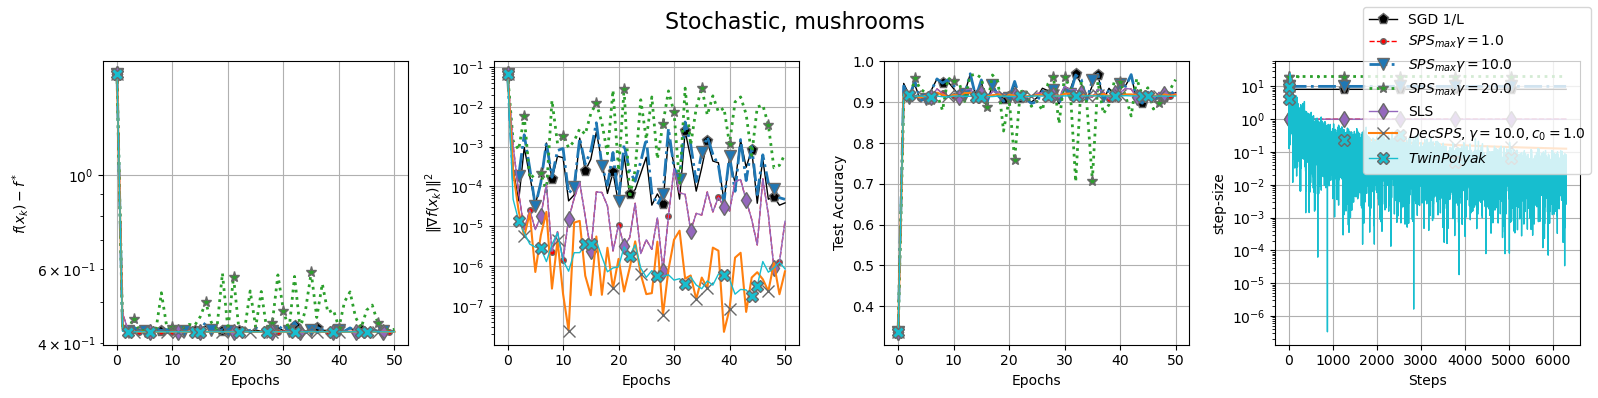

In [ ]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:orange", "tab:cyan"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.5, 1.0],
        markers=["p", ".", "v", "*", "d", "x", "X"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, {dataset_name}",
        prefix="train",
        threshold=0.0,
        apply_ma=False,
        # filename=f"rand_{dataset_name}_{setting.lower()}_logreg.pdf",
        )

In [ ]:
def twin_polyak_ma_WIP(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               seed: int = 0,
               beta: float = 0.9,
               eps: float = 0.0,
               ) -> dict: 
    
    np.random.seed(seed)

    train_data, train_target, test_data, test_target = dataset

    # parameters
    params_x = np.random.randn(train_data.shape[1])
    params_y = np.random.randn(train_data.shape[1])

    # oracle 
    loss_function = LogisticRegressionLoss(lmd=0.0)
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    # Train Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, train_data, train_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["train/loss"].append(loss)
    history["train/acc"].append(acc)
    history["train/grad_norm_sq"].append(g_norm_sq)
    
    # Test Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params_x, test_data, test_target)
    g_norm_sq = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm_sq"].append(g_norm_sq)
    
    fm_x = 0.0
    gm_x = np.zeros_like(params_x)
    gamma_x = 0.0
    
    fm_y = 0.0
    gm_y = np.zeros_like(params_y)
    gamma_y = 0.0
    
    # batch_size = int(train_data.shape[0] * 0.9)
    
    step_t = 0
    
    for epoch in range(n_epochs):
    
        # Training 
        if batch_size != train_data.shape[0]:
            np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
            
            loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, batch_data, batch_target)
            loss_y, grad_y, acc_y  = loss_function.func_grad_acc(params_y, batch_data, batch_target)

            fm_x = beta * fm_x + (1 - beta) * loss_x
            gamma_x = beta * gamma_x + (1 - beta) * np.dot(grad_x, params_x)
            gm_x = beta * gm_x + (1 - beta) * grad_x
            h_x = fm_x + (np.dot(gm_x, params_x) - gamma_x)
            
            fm_y = beta * fm_y + (1 - beta) * loss_y
            gamma_y = beta * gamma_y + (1 - beta) * np.dot(grad_y, params_y)
            gm_y = beta * gm_y + (1 - beta) * grad_y
            h_y = fm_y + np.dot(gm_y, params_y) - gamma_y

            if h_x > h_y:
                diff = h_x - h_y
                lr_x = diff / (0.5 * np.square(np.linalg.norm(gm_x)) + eps) 
                params_x -= lr_x * gm_x
                lr = lr_x
                history["train/batch/loss"].append(loss_y)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_y)**2)
            else:
                diff = h_y - h_x
                lr_y = diff / (0.5 * np.square(np.linalg.norm(gm_y)) + eps)
                params_y -= lr_y * gm_y
                lr = lr_y
                history["train/batch/loss"].append(loss_x)
                history["train/batch/grad_norm_sq"].append(np.linalg.norm(grad_x)**2)
            
            history["lr"].append(lr)
            
        # if (epoch + 1) % 20 == 0:
        #     batch_size = int(train_data.shape[0] * 0.1)
            
        # history["beta"].append(beta)
        # if (epoch + 1) % 20 == 0:
        #     if beta < 0.8:
        #         beta += 0.1
        #     else:
        #         beta = 0.9
        #     print(epoch, beta)
            
        # Train Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, train_data, train_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, train_data, train_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["train/loss"].append(loss)
        history["train/acc"].append(acc)
        history["train/grad_norm_sq"].append(g_norm_sq)
            
        # Test Evaluation 
        loss_x, grad_x, acc_x = loss_function.func_grad_acc(params_x, test_data, test_target)
        loss_y, grad_y, acc_y = loss_function.func_grad_acc(params_y, test_data, test_target)
        
        if loss_x < loss_y:
            loss, grad, acc, g_norm_sq = loss_x, grad_x, acc_x, np.linalg.norm(grad_x)**2
        else:
            loss, grad, acc, g_norm_sq = loss_y, grad_y, acc_y, np.linalg.norm(grad_y)**2
            
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm_sq"].append(g_norm_sq)

    return history

In [ ]:
n_epochs = 100
seed = 0

histories = []
labels = []
beta = 0.9

for eta_max in [1.0, 5.0, 10.0, 20.0]:
        hist_sps = train_loop(dataset=dataset,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        optimizer=SPS_MA,
                        seed=seed,
                        betas=(beta, beta),
                        eta_max=eta_max,
                        )
        histories.append(hist_sps)
        labels.append(r"$SPS_{{max}} MA, \eta_{{max}}={0}, \beta={1}$".format(eta_max, beta))

beta = 0.9
lr = 1.0
eps = 0.0
hist_momo = train_loop(dataset=dataset,
                batch_size=batch_size,
                n_epochs=n_epochs,
                optimizer=SGD_Momo,
                seed=seed,
                beta=beta,
                lr=lr,
                eps=eps
                )
histories.append(hist_momo)
labels.append(r"Momo, $\gamma_{{min}}={0}, \beta={1}$".format(lr, beta))

eps = 1e-6
for beta in [0.0, 0.9]:
        hist_twin_ma = twin_polyak_ma(dataset=dataset,
                        batch_size=batch_size,
                        n_epochs=n_epochs,
                        beta=beta,
                        eps=eps)

        histories.append(hist_twin_ma)
        labels.append(r"STP MA, $\beta={0}$".format(beta))

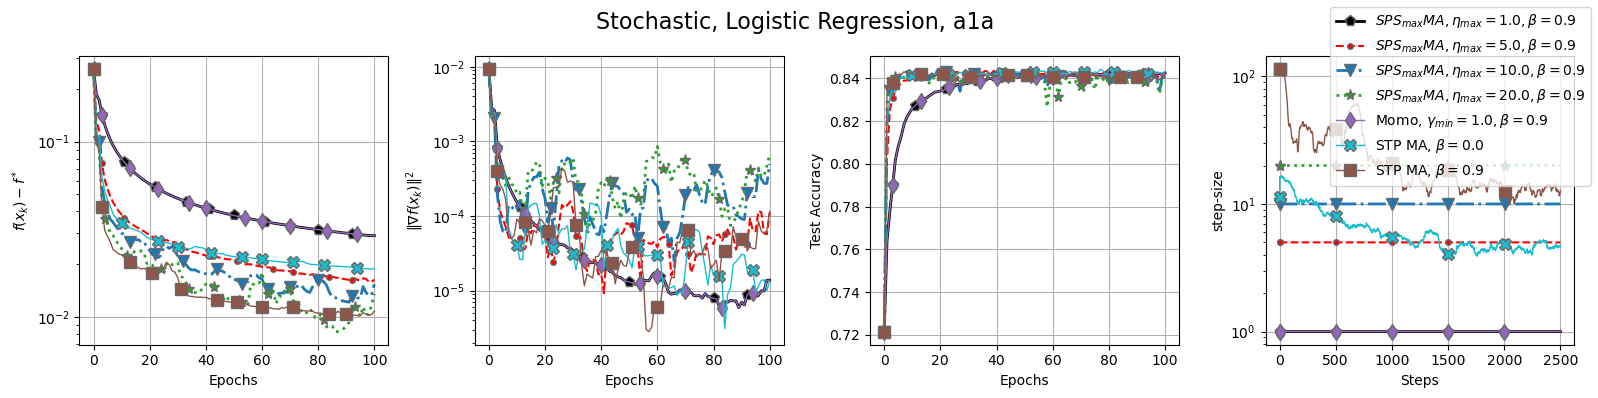

In [ ]:
plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple", "tab:cyan", "tab:brown"],
        linestyles=["-", "--", "-.", ":", "-", "-", "-"],
        linewidths=[2.0, 1.5, 2.0, 2.0, 1.0, 1.0, 1.0],
        markers=["p", ".", "v", "*", "d", "X", "s"],
        markeredgecolor="dimgrey",
        markersize=8,
        alphas=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        f_star=train_f_star, 
        suptitle=f"{setting}, Logistic Regression, {dataset_name}",
        prefix="train",
        threshold=0.0,
        # filename=f"momo-type-momentum_{dataset_name}.pdf",
        )